RNN podemos usar, pero is complex to train with longer sequences and can suffer from the problem of vanishing gradients

Hay otra variaciones como LSTM and GRU que no tienen este problema.

In [2]:
import pandas as pd
import scipy.io
import os
import mne
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from datetime import datetime
import math

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, Embedding, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, LearningRateScheduler

tf.random.set_seed(7)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
os.environ["CUDA_VISIBLE_DEVICES"]="0"

os.chdir("/home/caumel/Master/Project/DS_project_2022W/")

Num GPUs Available:  1


## Data

### Split files per wildboard and compute the areas points

In [3]:
# USE fiwi for train. becuase other in the positions we dont have too much data

In [3]:
path_files_fiwi = "../Join/telemetriedaten/positions_weather_fiwi/"
# path_files_other = "../Join/telemetriedaten/positions_weather_other/"

path_place_fiwi = "../Join/telemetriedaten/TelemetrieFiwigatter/"
# path_place_other = "../Join/telemetriedaten/TelemetrieJagdgatter/"

save_file_path = "../Join/telemetriedaten/position_per_wild_fiwi/"

In [4]:
list_files = os.listdir(path_files_fiwi)
wild_boards_fiwi = set()
for file in list_files:
    df = pd.read_csv(path_files_fiwi + file)
    wild_boards_fiwi.update(list(df["ID"].unique()))

# list_files = os.listdir(path_files_other)
# wild_boards_other = set()
# for file in list_files:
#     df = pd.read_csv(path_files_other + file)
#     wild_boards_other.update(list(df["ID"].unique()))

/tmp/ipykernel_210/796359707.py:4: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_files_fiwi + file)


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [5]:
wild_boards_fiwi = {
    'VG.2013.01', 'IS.2011.13', 'FG.2013.16', 'FG.2016.16', 'FG.2013.32', 'FG.2017.12', 'LA.2011.01', 'IS.2011.27',
    'IS.2011.05', 'VG.2013.10', 'IS.2011.20', 'FG.2013.29', 'FG.2016.14', 'FG.2017.11', 'IS.2011.29', 'FG.2016.13', 'IS.2011.10', 
    'IS.2011.37', 'FG.2016.15', 'FG.2016.17', 'FG.2013.09', 'LA.2011.03', 'DE.2011.19', 'IS.2011.21', 'IS.2011.39', 'FG.2017.09', 
    'DE.2011.27', 'IS.2011.32', 'DE.2011.23', 'VG.2013.09', 'FG.2017.18', 'IS.2011.12', 'IS.2011.26', 'IS.2011.25', 'IS.2011.02', 
    'IS.2011.23', 'FG.2016.12', 'FG.2016.03', 'DE.2011.21', 'IS.2011.04', 'IS.2011.11', 'DE.2011.18', 'FG.2016.05', 'FG.2016.07', 
    'FG.2017.16', 'FG.2016.18', 'FG.2017.13', 'IS.2011.22', 'FG.2013.01', 'FG.2013.06', 'VG.2013.02', 'IS.2011.36', 'FG.2017.14', 
    'DE.2011.20', 'FG.2017.17', 'IS.2011.15', 'IS.2011.34', 'DE.2011.14', 'VG.2013.08', 'IS.2011.14', 'DE.2011.25', 'IS.2011.01', 
    'IS.2011.38', 'FG.2013.34', 'FG.2013.25', 'IS.2011.33', 'VG.2013.11'}

In [7]:
for wild in wild_boards_fiwi:
    if not os.path.exists(os.path.join(save_file_path,wild)):
        os.mkdir(os.path.join(save_file_path,wild))

In [8]:
list_files = os.listdir(path_files_fiwi)
for file in list_files:
    df = pd.read_csv(path_files_fiwi + file)
    for wild in wild_boards_fiwi:
        df_to_save = df[df["ID"]==wild]
        df_to_save.to_csv(os.path.join(save_file_path,wild,file))

/tmp/ipykernel_229/2223551429.py:3: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_files_fiwi + file)
/tmp/ipykernel_229/2223551429.py:3: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_files_fiwi + file)
/tmp/ipykernel_229/2223551429.py:3: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_files_fiwi + file)
/tmp/ipykernel_229/2223551429.py:3: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_files_fiwi + file)
/tmp/ipykernel_229/2223551429.py:3: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_files_fiwi + file)
/tmp/ipykernel_229/2223551429.py:3: DtypeWarning: Columns (11) have mixed types. Specify dtype optio

In [5]:
# Create file of areas

file_areas = "../Join/telemetriedaten/TelemetrieFiwigatter/TelemetrieFiwigatter_Tel.Fiwi.csv"

df = pd.read_csv(file_areas)
df["start"] = pd.to_datetime(df["start"], infer_datetime_format=True)   
df["end"] = pd.to_datetime(df["end"], infer_datetime_format=True)   

# , "ID" "location","start","end","duration"
# 0,"DE.2011.23","Fiwi",2017-02-01 15:55:08,2017-02-01 15:58:13,3.08333333333333

df_2016 = df[(df["start"] > datetime.strptime("2016-01-01", '%Y-%m-%d')) & (df["start"] < datetime.strptime("2016-12-31", '%Y-%m-%d'))]
df_2017 = df[(df["start"] > datetime.strptime("2017-01-01", '%Y-%m-%d')) & (df["start"] < datetime.strptime("2017-12-31", '%Y-%m-%d'))]
df_2018 = df[(df["start"] > datetime.strptime("2018-01-01", '%Y-%m-%d')) & (df["start"] < datetime.strptime("2018-12-31", '%Y-%m-%d'))]
df_2019 = df[(df["start"] > datetime.strptime("2019-01-01", '%Y-%m-%d')) & (df["start"] < datetime.strptime("2019-12-31", '%Y-%m-%d'))]

In [ ]:
# Unnamed: 0               0.0.5196
# ID                     DE.2011.14
# location                     Fiwi
# start         2017-12-20 13:42:06
# end           2017-12-20 13:42:06
# duration                      0.0
# Name: 78109, dtype: object

df_final = pd.DataFrame(columns=["ID","Date","x-value","y-value","location"])

# for index_data,df in [df_2016,df_2017,df_2018,df_2019]:
for index, row in df.iloc[78100:,:].iterrows():
    id = row["ID"]
    init = row["start"]
    end = row["end"]
    location = row["location"]
    list_dayofcount = [value.strftime("%Y-%m-%d") for value in pd.date_range(start=init,end=end).to_list()]
    for day in list_dayofcount:
        try:
            df_day = pd.read_csv(os.path.join("../Join/telemetriedaten/position_per_wild_fiwi/" + id + "/",day + "_fiwi.csv"))
            df_day["Date"] = pd.to_datetime(df_day["Date"], infer_datetime_format=True)   
            df_to_save = df_day[(df_day["Date"] > init) & (df_day["Date"] < end)][["ID","Date","x-value", "y-value"]]
            df_to_save['location'] = location
            df_final = pd.concat([df_final,df_to_save.iloc[:,:]])
        except Exception as e:
            pass
df_final.to_csv(f"../Join/telemetriedaten/areas.csv")
    # df_final.to_csv(f"../Join/telemetriedaten/areas_{index_data+16}.csv")

In [39]:
df_final.to_csv("../Join/telemetriedaten/areas.csv")

### Fechas juntas

In [ ]:
# Wild board DE.2011.14
df = pd.DataFrame()
for file in os.listdir("../Join/telemetriedaten/position_per_wild_fiwi/DE.2011.14/"):
    print(file)
    df_day = pd.read_csv("../Join/telemetriedaten/position_per_wild_fiwi/DE.2011.14/" + file)
    df_day = df_day[['Date', 'tagid', 'MACadresse', 'x-value', 'y-value', 'ID', 'TempMain', 
                      'HumMain', 'Wind','WindDir', 'Rain', 'Solar', 'TempBB', 'TempForest', 'HumForest',
                      'BaroPressure', '°C_FG', 'hum_FG', 'dew_p_FG', '°C_VG', 'hum_VG', 'dew_p_VG', 'SuhlenVG', 'SuhlenFG']]
    df = pd.concat([df,df_day.iloc[:,:]])
df.to_csv("../Join/telemetriedaten/position_per_wild_fiwi/DE.2011.14/DE.2011.14.csv")

## Data preparation

In [3]:
# Wild board DE.2011.14
path_file = "../Join/telemetriedaten/position_per_wild_fiwi/DE.2011.14/DE.2011.14.csv"
df = pd.read_csv(path_file)
df = df.set_index('Date')
df = df.drop(columns=["Unnamed: 0","tagid","MACadresse","ID"])
ohe = pd.get_dummies(df.WindDir)
df = df.drop('WindDir',axis = 1)
# df = df.join(ohe)

/tmp/ipykernel_227/693688132.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_file)


In [4]:
df= df.interpolate(method='linear',limit_direction='both')

In [5]:
# LSTMs are sensitive to the scale of the input data

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0,1))
df[['TempMain', 'HumMain', 'Wind', 'Rain', 'Solar','TempBB', 'TempForest',
    'HumForest', 'BaroPressure', '°C_FG', 'hum_FG', 'dew_p_FG', '°C_VG',
    'hum_VG', 'dew_p_VG', 'SuhlenVG', 'SuhlenFG']] = scaler.fit_transform(df[['TempMain', 'HumMain', 'Wind', 'Rain', 'Solar',
                                                                              'TempBB', 'TempForest', 'HumForest', 'BaroPressure', '°C_FG', 'hum_FG',
                                                                              'dew_p_FG', '°C_VG', 'hum_VG', 'dew_p_VG', 'SuhlenVG', 'SuhlenFG']])

In [6]:
# dataset is transformed into a supervised learning problem  t -> t+1
df_temporal = df.copy() #.iloc[10000:20000,:]
df_temporal[["x-value_t-1","y-value_t-1"]] = df_temporal[["x-value","y-value"]]
df_temporal[["x-value","y-value"]] = df_temporal[["x-value","y-value"]].shift(-1)
df_temporal = df_temporal.dropna(subset=["x-value","y-value"])

In [7]:
# Split dataset 

# df_solo_position = df_temporal[["x-value_t-1","y-value_t-1","x-value","y-value"]]

values = df_temporal.values
values = values.astype('float32')
length = values.shape[0]

train, validation, test = np.split(df_temporal, [int(.8 * len(df_temporal)), int(.9 * len(df_temporal))])


X_train, y_train = train.drop(columns=["x-value","y-value"]).values,  train[["x-value","y-value"]].values
X_validation, y_validation = validation.drop(columns=["x-value","y-value"]).values,  validation[["x-value","y-value"]].values
X_test, y_test = test.drop(columns=["x-value","y-value"]).values,  test[["x-value","y-value"]].values

In [8]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_validation = X_validation.reshape((X_validation.shape[0], 1, X_validation.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [9]:
print(X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape)

(970955, 1, 19) (970955, 2) (121369, 1, 19) (121369, 2) (121370, 1, 19) (121370, 2)


## Model and miscelaneous

In [10]:
def create_LSTM_model(data, data_size):
    model = Sequential()
    # Masking layer for pre-trained embeddings
    model.add(LSTM(units=data_size, input_shape=(data.shape[1], data.shape[2]), dtype='float32'))
    # Fully connected layer
    model.add(Dense(64, activation='relu'))
    # Dropout for regularization
    model.add(Dropout(0.5))
    # Output layer
    model.add(Dense(2))
    model._name="LSTM_model"
    return model

def create_LSTM_model_2(data, data_size):
    model = Sequential()
    # Masking layer for pre-trained embeddings
    model.add(LSTM(units=data_size, input_shape=(data.shape[1], data.shape[2]), dtype='float32'))
    # Output layer
    model.add(Dense(2))
    model._name="LSTM_model_2"
    return model

## Train model

In [11]:
lr_scheduler = 0.1
batch_size = 128
epochs = 50
units = 128

In [14]:
# model = create_LSTM_model(X_train,units)
model = create_LSTM_model_2(X_train,units)
model.summary()

Model: "LSTM_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               75776     
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
Total params: 76,034
Trainable params: 76,034
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Create callbacks

def scheduler(epoch, lr):
   initial_lrate = lr_scheduler
   drop = 0.75
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate

callbacks = [
                # EarlyStopping(monitor='val_loss', patience=5),
                LearningRateScheduler(scheduler),
                ModelCheckpoint(f'models/{datetime.now()}_model.h5', save_best_only=True, save_weights_only=False),
                CSVLogger(f'logs/{datetime.now()}_training.log')
            ]

In [17]:
def custom_loss(y_true, y_pred):
    return tf.norm(y_true-y_pred, ord='euclidean')

opt = tf.keras.optimizers.Adam()#learning_rate=0.1)
# opt = tf.keras.optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=opt, loss=custom_loss, metrics=['accuracy'])

In [18]:
history = model.fit(X_train,  y_train, 
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=(X_validation, y_validation),
                    # verbose=2,
                    shuffle=False)

Epoch 1/50


2023-02-05 17:28:01.715303: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-02-05 17:28:03.537721: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-05 17:28:03.631714: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fe95e060f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-05 17:28:03.631784: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-02-05 17:28:03.666479: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


   1/7586 [..............................] - ETA: 10:14:05 - loss: 0.7816 - accuracy: 0.0000e+00

2023-02-05 17:28:04.044887: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-05 17:28:04.136389: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7586/7586 [==============================] - 48s 6ms/step - loss: 94.3903 - accuracy: 0.9726 - val_loss: 101.3223 - val_accuracy: 0.9756 - lr: 0.1000
Epoch 2/50
7586/7586 [==============================] - 41s 5ms/step - loss: 85.1588 - accuracy: 0.9752 - val_loss: 77.3946 - val_accuracy: 0.9820 - lr: 0.1000
Epoch 3/50
7586/7586 [==============================] - 40s 5ms/step - loss: 75.2750 - accuracy: 0.9757 - val_loss: 79.7767 - val_accuracy: 0.9800 - lr: 0.1000
Epoch 4/50
7586/7586 [==============================] - 40s 5ms/step - loss: 74.9947 - accuracy: 0.9741 - val_loss: 72.5058 - val_accuracy: 0.9820 - lr: 0.1000
Epoch 5/50
7586/7586 [==============================] - 38s 5ms/step - loss: 73.0818 - accuracy: 0.9759 - val_loss: 71.6466 - val_accuracy: 0.9804 - lr: 0.1000
Epoch 6/50
7586/7586 [==============================] - 38s 5ms/step - loss: 74.3445 - accuracy: 0.9757 - val_loss: 68.8018 - val_accuracy: 0.9840 - lr: 0.1000
Epoch 7/50
7586/7586 [============================

In [185]:
# Save data
csv_logger = CSVLogger('training.log')
model.save('model.h5')

## Results

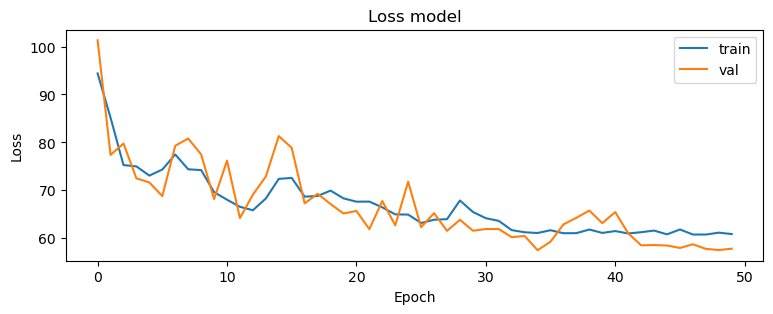

<Figure size 640x480 with 0 Axes>

In [26]:
# plot history
fig, ax = plt.subplots(figsize=(9, 3))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("Loss model")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'figures/train_loss_{lr_scheduler}_{batch_size}_{epochs}_{units}_{datetime.now()}.png')
plt.show()

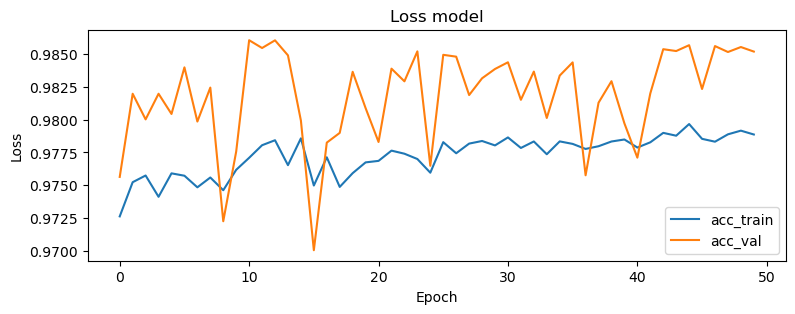

In [27]:
fig, ax = plt.subplots(figsize=(9, 3))
plt.plot(history.history['accuracy'], label='acc_train')
plt.plot(history.history['val_accuracy'], label='acc_val')
plt.title("Loss model")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'figures/train_acc_{lr_scheduler}_{batch_size}_{epochs}_{units}.png')
plt.show()

In [28]:
from sklearn.metrics import mean_squared_error
import math

# make a prediction
y_pred = model.predict(X_test)
# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: %.3f' % rmse)

3793/3793 [==============================] - 10s 2ms/step
Test RMSE: 3.063


In [29]:
# Loss 
distance = np.linalg.norm(np.array(y_test) - np.array(y_pred))
mean_distance = distance / len(y_test)

print("Average distance:", mean_distance)

Average distance: 0.012435528144816745


In [30]:
y_test_x = [item[0] for item in y_test]
y_test_y = [item[1] for item in y_test]

y_pred_x = [item[0] for item in y_pred]
y_pred_y = [item[1] for item in y_pred]

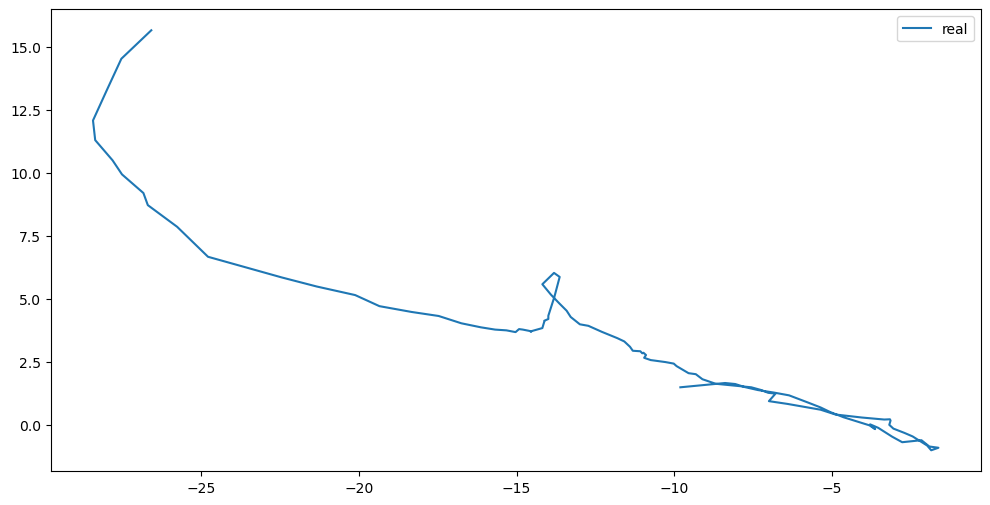

In [31]:
# plot history
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(y_test_x[500:600],y_test_y[500:600],label='real')
# pyplot.plot(y_pred_x[500:600],y_pred_y[500:600],label='pred')
plt.legend()
# plt.savefig(f'figures/y_test_{lr_scheduler}_{batch_size}_{epochs}_{units}.png')
plt.show()

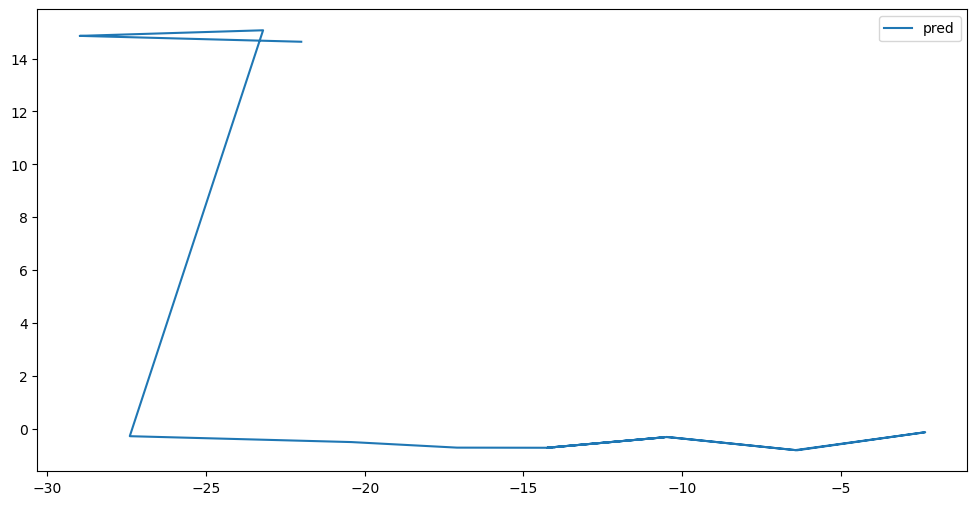

In [32]:
# plot history
fig, ax = plt.subplots(figsize=(12, 6))
# plt.plot(y_test_x[500:600],y_test_y[500:600],label='real')
plt.plot(y_pred_x[500:600],y_pred_y[500:600],label='pred')
plt.legend()
# plt.savefig(f'figures/y_pred_{lr_scheduler}_{batch_size}_{epochs}_{units}.png')
plt.show()

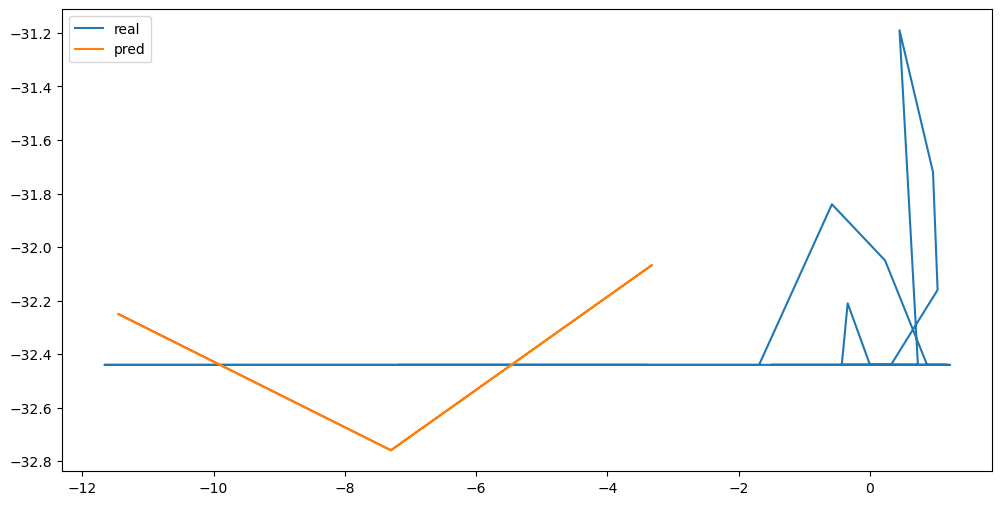

In [74]:
# plot history
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(y_test_x[500:700],y_test_y[500:700],label='real')
plt.plot(y_pred_x[500:700],y_pred_y[500:700],label='pred')
plt.legend()
# plt.savefig(f'figures/y_pred_compare_{lr_scheduler}_{batch_size}_{epochs}_{units}.png')
plt.show()

In [34]:
y_pred_val = model.predict(X_validation)
y_test_x = [item[0] for item in y_validation]
y_test_y = [item[1] for item in y_validation]

y_pred_x = [item[0] for item in y_pred_val]
y_pred_y = [item[1] for item in y_pred_val]

3793/3793 [==============================] - 8s 2ms/step


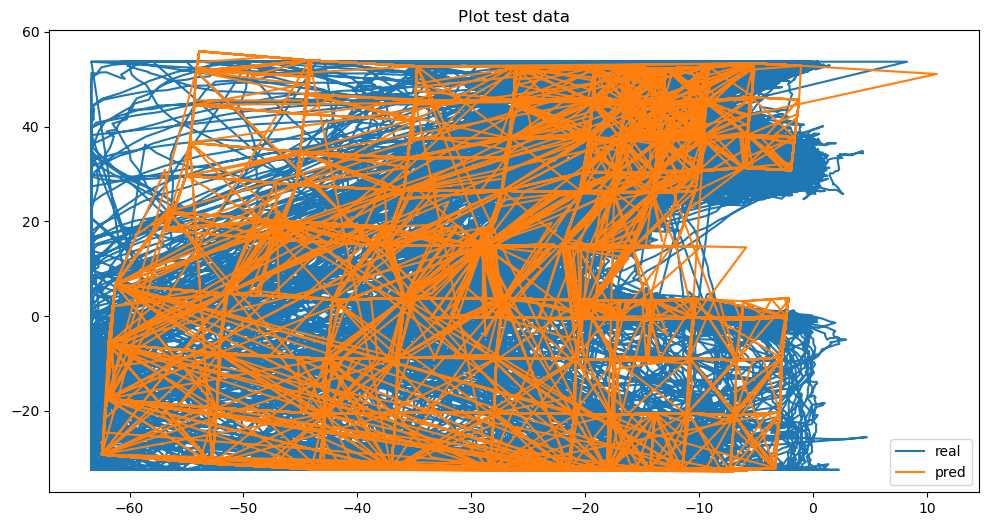

In [39]:
# plot history
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(y_test_x[:],y_test_y[:],label='real')
plt.plot(y_pred_x[:],y_pred_y[:],label='pred')
plt.title("Plot test data")
plt.legend()
plt.savefig(f'figures/general_map.png')
plt.show()

### Second wild board

In [62]:
# Join data

# Wild board IS.2011.04
df = pd.DataFrame()
for file in os.listdir("../Join/telemetriedaten/position_per_wild_fiwi/IS.2011.04/"):
    df_day = pd.read_csv("../Join/telemetriedaten/position_per_wild_fiwi/IS.2011.04/" + file)
    df_day = df_day[['Date', 'tagid', 'MACadresse', 'x-value', 'y-value', 'ID', 'TempMain', 
                      'HumMain', 'Wind','WindDir', 'Rain', 'Solar', 'TempBB', 'TempForest', 'HumForest',
                      'BaroPressure', '°C_FG', 'hum_FG', 'dew_p_FG', '°C_VG', 'hum_VG', 'dew_p_VG', 'SuhlenVG', 'SuhlenFG']]
    df = pd.concat([df,df_day.iloc[:,:]])
df.to_csv("../Join/telemetriedaten/position_per_wild_fiwi/IS.2011.04/IS.2011.04.csv")

In [63]:
# Wild board DE.2011.14
path_file = "../Join/telemetriedaten/position_per_wild_fiwi/IS.2011.04/IS.2011.04.csv"
df = pd.read_csv(path_file)
df = df.set_index('Date')
df = df.drop(columns=["Unnamed: 0","tagid","MACadresse","ID"])
ohe = pd.get_dummies(df.WindDir)
df = df.drop('WindDir',axis = 1)
# df = df.join(ohe)

df= df.interpolate(method='linear',limit_direction='both')

# LSTMs are sensitive to the scale of the input data

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0,1))
df[['TempMain', 'HumMain', 'Wind', 'Rain', 'Solar','TempBB', 'TempForest',
    'HumForest', 'BaroPressure', '°C_FG', 'hum_FG', 'dew_p_FG', '°C_VG',
    'hum_VG', 'dew_p_VG', 'SuhlenVG', 'SuhlenFG']] = scaler.fit_transform(df[['TempMain', 'HumMain', 'Wind', 'Rain', 'Solar',
                                                                              'TempBB', 'TempForest', 'HumForest', 'BaroPressure', '°C_FG', 'hum_FG',
                                                                              'dew_p_FG', '°C_VG', 'hum_VG', 'dew_p_VG', 'SuhlenVG', 'SuhlenFG']])

# dataset is transformed into a supervised learning problem  t -> t+1
df_temporal = df.copy() #.iloc[10000:20000,:]
df_temporal[["x-value_t-1","y-value_t-1"]] = df_temporal[["x-value","y-value"]]
df_temporal[["x-value","y-value"]] = df_temporal[["x-value","y-value"]].shift(-1)
df_temporal = df_temporal.dropna(subset=["x-value","y-value"])

# Split dataset 

# df_solo_position = df_temporal[["x-value_t-1","y-value_t-1","x-value","y-value"]]

values = df_temporal.values
values = values.astype('float32')
length = values.shape[0]

train_2, validation_2, test_2 = np.split(df_temporal, [int(.8 * len(df_temporal)), int(.9 * len(df_temporal))])


X_train_2, y_train_2 = train_2.drop(columns=["x-value","y-value"]).values,  train_2[["x-value","y-value"]].values
X_validation_2, y_validation_2 = validation_2.drop(columns=["x-value","y-value"]).values,  validation_2[["x-value","y-value"]].values
X_test_2, y_test_2 = test_2.drop(columns=["x-value","y-value"]).values,  test_2[["x-value","y-value"]].values

X_train_2 = X_train_2.reshape((X_train_2.shape[0], 1, X_train_2.shape[1]))
X_validation_2 = X_validation_2.reshape((X_validation_2.shape[0], 1, X_validation_2.shape[1]))
X_test_2 = X_test_2.reshape((X_test_2.shape[0], 1, X_test_2.shape[1]))

/tmp/ipykernel_227/2982113816.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_file)


In [64]:
def scheduler(epoch, lr):
   initial_lrate = lr_scheduler
   drop = 0.5
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate

callbacks = [
                # EarlyStopping(monitor='val_loss', patience=5),
                LearningRateScheduler(scheduler),
                ModelCheckpoint(f'models/{datetime.now()}_model.h5', save_best_only=True, save_weights_only=False),
                CSVLogger(f'logs/{datetime.now()}_training.log')
            ]

# model = create_LSTM_model(X_train,units)
model_2 = create_LSTM_model_2(X_train,units)

opt = tf.keras.optimizers.Adam()#learning_rate=0.1)
model_2.compile(optimizer=opt, loss=custom_loss, metrics=['accuracy'])

history_2 = model_2.fit(X_train_2,  y_train_2, 
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=(X_validation_2, y_validation_2),
                    # verbose=2,
                    shuffle=False)

Epoch 1/50
4368/4368 [==============================] - 28s 6ms/step - loss: 101.3818 - accuracy: 0.9866 - val_loss: 96.4385 - val_accuracy: 0.9978 - lr: 0.1000
Epoch 2/50
4368/4368 [==============================] - 26s 6ms/step - loss: 77.0083 - accuracy: 0.9881 - val_loss: 78.7807 - val_accuracy: 0.9966 - lr: 0.1000
Epoch 3/50
4368/4368 [==============================] - 24s 5ms/step - loss: 71.4059 - accuracy: 0.9882 - val_loss: 87.7267 - val_accuracy: 0.9953 - lr: 0.1000
Epoch 4/50
4368/4368 [==============================] - 24s 5ms/step - loss: 73.0859 - accuracy: 0.9865 - val_loss: 77.1779 - val_accuracy: 0.9976 - lr: 0.1000
Epoch 5/50
4368/4368 [==============================] - 24s 5ms/step - loss: 71.0560 - accuracy: 0.9875 - val_loss: 77.3617 - val_accuracy: 0.9977 - lr: 0.1000
Epoch 6/50
4368/4368 [==============================] - 26s 6ms/step - loss: 70.6196 - accuracy: 0.9880 - val_loss: 79.8527 - val_accuracy: 0.9959 - lr: 0.1000
Epoch 7/50
4368/4368 [=================

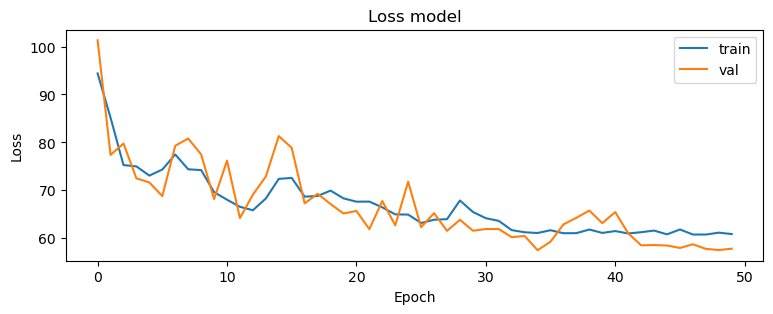

In [65]:
# plot history
fig, ax = plt.subplots(figsize=(9, 3))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("Loss model")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'figures/train_loss_{lr_scheduler}_{batch_size}_{epochs}_{units}_{datetime.now()}.png')
plt.show()

In [67]:
from sklearn.metrics import mean_squared_error
import math

# make a prediction
y_pred_2 = model_2.predict(X_test_2)
# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_test_2, y_pred_2))
print('Test RMSE: %.3f' % rmse)

2184/2184 [==============================] - 4s 2ms/step
Test RMSE: 5.856


In [68]:
y_test_x_2 = [item[0] for item in y_test_2]
y_test_y_2 = [item[1] for item in y_test_2]

y_pred_x_2 = [item[0] for item in y_pred_2]
y_pred_y_2 = [item[1] for item in y_pred_2]

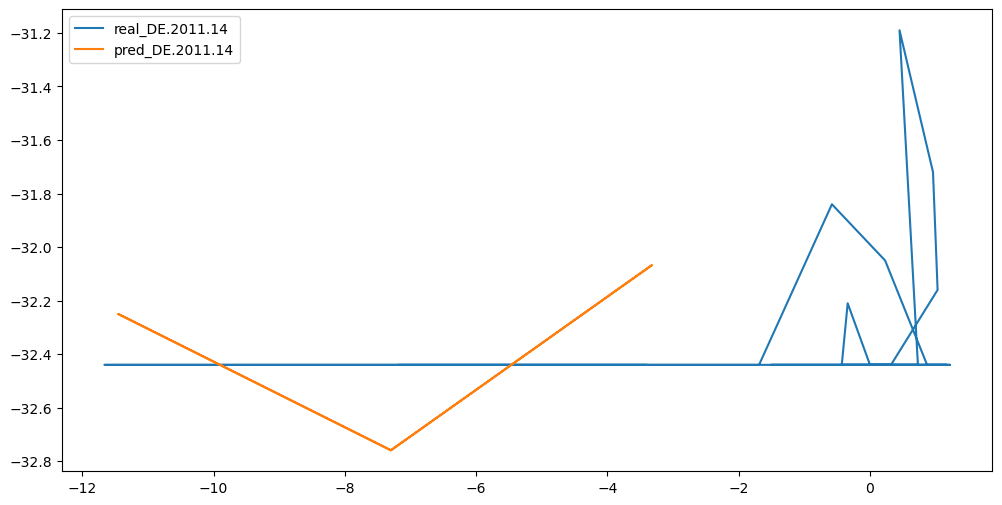

In [70]:
# plot history
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(y_test_x[500:700],y_test_y[500:700],label='real_DE.2011.14')
plt.plot(y_pred_x[500:700],y_pred_y[500:700],label='pred_DE.2011.14')
plt.legend()
# plt.savefig(f'figures/y_pred_compare_{lr_scheduler}_{batch_size}_{epochs}_{units}.png')
plt.show()

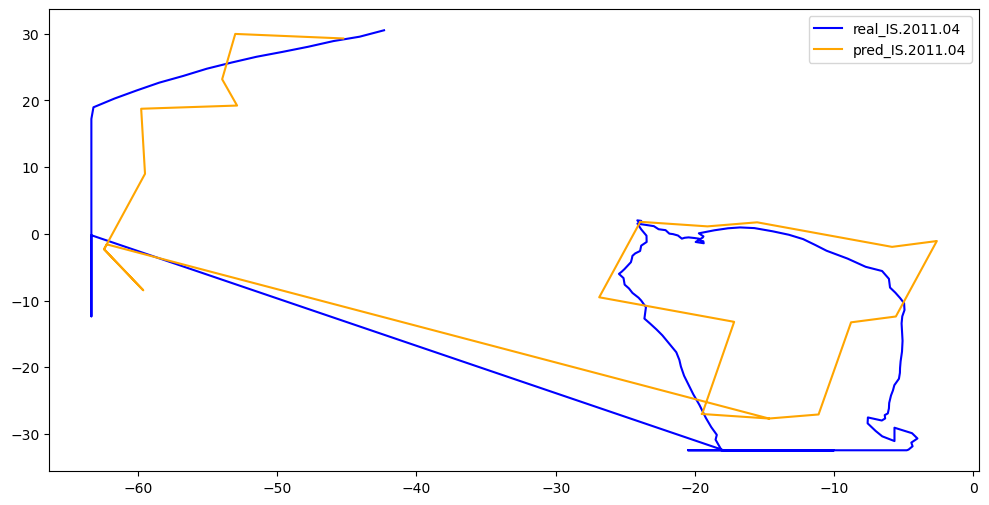

In [80]:
# plot history
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(y_test_x_2[1200:1400],y_test_y_2[1200:1400],label='real_IS.2011.04', color="blue")
plt.plot(y_pred_x_2[1200:1400],y_pred_y_2[1200:1400],label='pred_IS.2011.04', color="orange")
plt.legend()
plt.savefig(f'figures/y_pred_compare_{lr_scheduler}_{batch_size}_{epochs}_{units}_IS.2011.04.png')
plt.show()